In [154]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import yaml
import matplotlib.pyplot as plt 
import datetime

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format
theme_set(theme_linedraw()) # default theme

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import yaml
from jinja2 import Template
cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))

# Manipulation 
from siuba import *

In [17]:
from src import utils
from datetime import datetime
conn = utils.connect_athena(path='../configs/athena.yaml')

In [101]:
# Equivale a athena spd_sdv_waze_corona.prod_daily_daily_index
df = pd.read_csv('~/shared/spd-sdv-omitnik-waze/corona/prod/private/daily/write_index/write_index_daily.csv', 
                 sep = "|")

df = df[df.month != 'TRUE']

In [102]:
df['month'] = df.month.astype(str).astype(int)
df['day']   = df.day.astype(int)
df['year'] = 2020
df['year'][df.month <= 2] = 2021
df['date'] = pd.to_datetime(df[['year','month','day']]
                            .astype(str).apply(' '.join, 1), format='%Y %m %d')
df['datetime'] = df['date'].astype(str).apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
df.head()

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,month,day,dow,observed,expected_2020,ratio_20,tci,dashboard,year,date,datetime
0,2021-02-02 11:02:14.564,porto_alergre,Porto Alegre,Brazil,BR,BR,city,3385942.0,NaN,9,2,3.0,19691083.0,24980652.0,0.788253,-21.174663,True,2020,2020-09-02,2020-09-02
1,2021-02-02 11:02:14.564,porto_alergre,Porto Alegre,Brazil,BR,BR,city,3385942.0,NaN,4,1,3.0,4016647.0,24980652.0,0.160790,-83.920968,True,2020,2020-04-01,2020-04-01
2,2021-02-02 11:02:14.564,porto_alergre,Porto Alegre,Brazil,BR,BR,city,3385942.0,NaN,12,23,3.0,26317209.0,24980652.0,1.053504,5.350369,True,2020,2020-12-23,2020-12-23
3,2021-02-02 11:02:14.564,porto_alergre,Porto Alegre,Brazil,BR,BR,city,3385942.0,NaN,4,15,3.0,4728878.0,24980652.0,0.189302,-81.069838,True,2020,2020-04-15,2020-04-15
4,2021-02-02 11:02:14.564,porto_alergre,Porto Alegre,Brazil,BR,BR,city,3385942.0,NaN,11,11,3.0,22147369.0,24980652.0,0.886581,-11.341910,True,2020,2020-11-11,2020-11-11


In [103]:
print(min(df.date))
print(max(df.date))
df.describe()

2020-03-09 00:00:00
2021-02-01 00:00:00


,population,month,day,dow,observed,expected_2020,ratio_20,tci,year
count,2.682300e+04,35743.000000,35743.000000,35743.000000,3.574300e+04,3.574300e+04,35743.000000,35743.000000,35743.000000
mean,9.553237e+06,6.982850,16.050555,3.991103,3.769980e+07,4.759317e+07,0.801266,-19.873388,2020.096970
std,2.789319e+07,3.311224,8.791426,2.003824,1.310761e+08,1.191257e+08,0.874869,87.486884,0.295921
min,2.873710e+05,1.000000,1.000000,1.000000,2.911000e+03,1.904530e+05,0.001573,-99.842676,2020.000000
25%,1.029073e+06,4.000000,9.000000,2.000000,2.528918e+06,5.018336e+06,0.321955,-67.804490,2020.000000
50%,2.134483e+06,7.000000,16.000000,4.000000,8.393557e+06,1.328042e+07,0.597996,-40.200408,2020.000000
75%,5.094114e+06,10.000000,24.000000,6.000000,2.557598e+07,3.978585e+07,0.977345,-2.265461,2020.000000
max,2.125594e+08,12.000000,31.000000,7.000000,3.742041e+09,1.312398e+09,19.282253,1828.225281,2021.000000


In [152]:
print(len(df['region_slug'].unique()))
df['country_name'].unique()

108


array(['Brazil', 'Colombia', 'Panama', 'Chile', 'Mexico', 'Ecuador',
       'Argentina', 'Barbados', 'Bolivia', 'Nicaragua', 'El Salvador',
       'Peru', 'Honduras', 'Dominican Republic', 'Uruguay', 'Jamaica',
       'Trinidad and Tobago', 'Paraguay', 'Costa Rica', 'Guatemala'],
      dtype=object)

Promedio de tci por region, día

In [209]:
tab = df \
  .siu_group_by('region_slug', "country_name", "date") \
  .siu_summarize(nc = _.tci.count(),
                 tci = _.tci.mean(),
                 tci_min = _.tci.min(),
                 tci_max = _.tci.max()) \
  .siu_ungroup()

In [210]:
tab.head()

,region_slug,country_name,date,nc,tci,tci_min,tci_max
0,aguascalientes,Mexico,2020-03-09,1,-42.103947,-42.103947,-42.103947
1,aguascalientes,Mexico,2020-03-10,1,3.740975,3.740975,3.740975
2,aguascalientes,Mexico,2020-03-11,1,8.477060,8.477060,8.477060
3,aguascalientes,Mexico,2020-03-12,1,13.016856,13.016856,13.016856
4,aguascalientes,Mexico,2020-03-13,1,-6.457111,-6.457111,-6.457111


In [211]:
print(tab.shape)
tab.siu_filter(_.nc > 1).shape

(35640, 7)


(103, 7)

In [212]:
tab.siu_filter(_.nc > 1).head()

,region_slug,country_name,date,nc,tci,tci_min,tci_max
1162,belem,Brazil,2020-08-28,2,-7.890367,-7.890367,-7.890367
1281,belem,Brazil,2020-12-25,2,-62.294706,-62.294706,-62.294706
7938,br_states_rio_de_janeiro,Brazil,2020-03-27,2,-87.436639,-87.436639,-87.436639
7980,br_states_rio_de_janeiro,Brazil,2020-05-08,2,-71.901663,-71.901663,-71.901663
8050,br_states_rio_de_janeiro,Brazil,2020-07-17,2,-29.474743,-29.474743,-29.474743


### TCI time serie per region

In [213]:
region_par = 'Mexico'

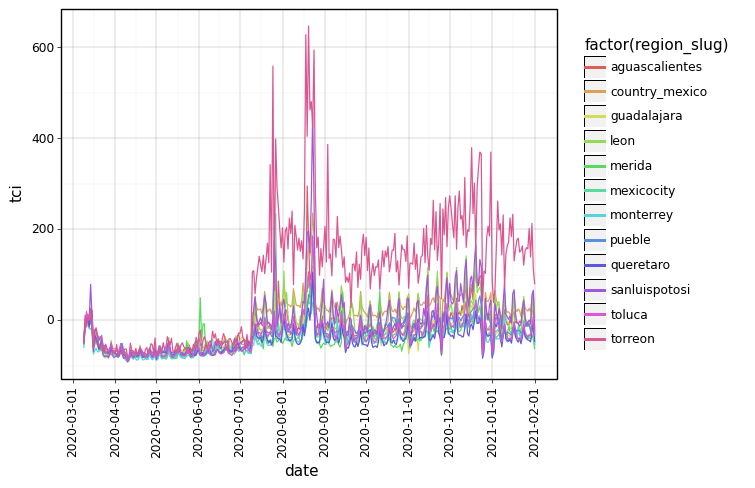

<ggplot: (8787513648461)>

In [214]:
(ggplot(filter(tab, _.country_name==region_par),
        aes('date', 'tci', color='factor(region_slug)'))
 + geom_line()
# + geom_point()
 + theme(axis_text_x=element_text(angle=90)))

In [217]:
df_ft = filter(tab,
               _.country_name==region_par, #_.region_slug=='aguascalientes'
              )
a = df_ft[['date', 'tci', 'region_slug']]
a.pivot(index='date', columns='region_slug', values='tci').iplot(
    #theme='custom',
    yTitle='TCI',
    title='TCI',
    #asImage=True
)